# Collaboration and Competition



###  Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
       
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from collections import deque,namedtuple
import random
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#action_space: sin(theta),cos(theta) of both joints. Hence, size=4
BUFFER_SIZE= int(1e5) 
BATCH_SIZE= 256
GAMMA=0.99
TAU=0.001
LR_ACTOR=1e-4
LR_CRITIC=1e-3
WEIGHT_DECAY = 0        


cuda:0


In [7]:
def hidden_init(layer):
    inp_fan = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(inp_fan)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=150):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=200, fc2_units=150):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size) * num_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [8]:
class ReplayBuffer:

    def __init__(self, buffer_size, batch_size):
       
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):

        return len(self.memory)

In [9]:
import copy
class OUNoise:

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):

        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()  
        
    def reset(self):

        self.state = copy.copy(self.mu)

    def sample(self):

        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

In [10]:
class DDPGAgent():
    
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        
        # ACTOR NETWORKS
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=LR_ACTOR)

        # CRITIC NETWORKS
        self.critic_local = Critic(state_size, action_size , random_seed).to(device)
        self.critic_target = Critic(state_size, action_size , random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # noise processing
        self.noise = OUNoise(action_size, random_seed)
            
    def step(self):
        
        if len(sharedBuffer)>BATCH_SIZE:
            experiences = sharedBuffer.sample()
            self.learn(experiences,GAMMA)        

    def act(self, state, add_noise=True):

        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
       
        states_list, actions_list, rewards, next_states_list, dones = experiences
        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)
        
        #UPDATE CRITIC 
        next_actions = [self.actor_target(states) for states in states_list]        
        next_actions_tensor = torch.cat(next_actions, dim=1).to(device)        
        Q_targets_next = self.critic_target(next_states_tensor, next_actions_tensor)        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        #UPDATE ACTOR
        actions_pred = [self.actor_local(states) for states in states_list]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(states_tensor, actions_pred_tensor).mean()        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        self.actor_optimizer.step()

        #UPDATE NETWORKS
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
      
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [11]:
class MADDPG:

    def __init__(self, random_seed):
        self.agents = [DDPGAgent(state_size,action_size,random_seed) for x in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        sharedBuffer.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def save_weights(self):
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), "actor_weights.pth")
            torch.save(agent.critic_local.state_dict(), "critic_weights.pth")
    
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [12]:
maddpg_agent = MADDPG(0)
sharedBuffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

def train_mddpg(n_episodes=3000):
    scores = []
    average_scores_list = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):                                    
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)
        maddpg_agent.reset()

        while True:
            
            actions = maddpg_agent.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            maddpg_agent.step(states, actions, rewards, next_states, dones)        
            states = next_states
            score += rewards  

            if any(dones):                                 
                break

        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")  

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score: {:.3f}'.format(i_episode , average_score))

        if average_score >= 0.5:
            maddpg_agent.save_weights()
            print("\rSolved in episode: {} \tAverage score: {:.3f}".format(i_episode , average_score))
            break
    return scores , average_scores_list

In [13]:
scores , average_scores_list = train_mddpg()

Episode 100	Average score: 0.001
Episode 200	Average score: 0.001
Episode 300	Average score: 0.002
Episode 400	Average score: 0.014
Episode 500	Average score: 0.022
Episode 600	Average score: 0.012
Episode 700	Average score: 0.006
Episode 800	Average score: 0.042
Episode 900	Average score: 0.075
Episode 1000	Average score: 0.084
Episode 1100	Average score: 0.129
Episode 1200	Average score: 0.155
Episode 1300	Average score: 0.238
Episode 1400	Average score: 0.338
Solved in episode: 1467 	Average score: 0.509


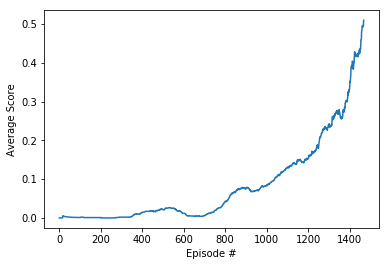

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores_list)+1), average_scores_list)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()